In [1]:
import sys
path2cpp_pkg = "/Users/mariusmahiout/Documents/repos/ising_core/build"
sys.path.append(path2cpp_pkg)
import ising

import os
os.chdir("/Users/mariusmahiout/Documents/repos/ising_core/python")
import src.utils as utils
import src.model_eval as eval
import src.isingfitter as fitter
import src.misc_plotting as plotting

os.chdir("..")


import numpy as np
import plotly
from IPython.display import display, HTML

plotly.offline.init_notebook_mode()
display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))

In [53]:
num_units = 200
num_sims = 15_000
num_burn = 1000

In [54]:
##############
# SIMULATION #
##############

# setting up model
beta = 1
h = np.random.uniform(-.3 * beta, .3 * beta, num_units)
J = np.random.normal(0,  beta / np.sqrt(num_units), (num_units, num_units))
for i in range(num_units):
    J[i, i] = 0
    for j in range(i+1, num_units):
        J[j, i] = J[i, j]

true_model = ising.NeqModel(J, h)

# simulating
true_sim = true_model.simulate(int(num_sims/0.7), num_burn)

In [55]:
#train_sample, test_sample = utils.get_train_test_samples(true_sim)
train_sample = true_sim
test_sample = true_sim

# Gradient ascent

In [56]:
lr = 0.1
win_size = 10
tol_ml = 1e-4
max_steps = 3000

In [57]:
##############
# LIKELIHOOD #
##############

# setting up model
h_init = np.random.uniform(-1.5, 1.5, num_units)
J_init = np.random.normal(0,  1,  (num_units, num_units))
J_init = (J_init.T + J_init) * np.sqrt(2) / 2
np.fill_diagonal(J_init, 0)

ml_model = ising.NeqModel(J_init, h_init)

ml_fitter = fitter.NeqFitter(ml_model)
#ml_fitter.TAP(true_sim)

# inference
use_llh = False
ml_fitter.maximize_likelihood(
    sample=train_sample, 
    max_steps=1000, 
    learning_rate=0.5,
    win_size = win_size,
    tolerance= tol_ml, 
    calc_llh=use_llh
)

ml_fitter.maximize_likelihood(
    sample=train_sample, 
    max_steps=1000, 
    learning_rate=0.1,
    win_size = win_size,
    tolerance= tol_ml, 
    calc_llh=use_llh
)

ml_fitter.maximize_likelihood(
    sample=train_sample, 
    max_steps=1000, 
    learning_rate=0.05,
    win_size = win_size,
    tolerance= tol_ml, 
    calc_llh=use_llh
)



In [58]:
plotting.convergence_plot(ml_fitter, plot_llh=use_llh, path="./analyses/neq_convergence/ml200.pdf")

Button(description='Save Figure', style=ButtonStyle())

In [64]:
nmf_model = ising.NeqModel(J_init, h_init)
nmf_fitter = fitter.NeqFitter(nmf_model)
nmf_fitter.naive_mean_field(train_sample)

tap_model = ising.NeqModel(J_init, h_init)
tap_fitter = fitter.NeqFitter(tap_model)
tap_fitter.TAP(train_sample)


In [65]:
ml_sim = ml_model.simulate(num_sims, num_burn)
nmf_sim = nmf_model.simulate(num_sims, num_burn)
tap_sim = tap_model.simulate(num_sims, num_burn)

In [66]:


labels = ["nMF", "TAP", "ML"]
metadata = utils.get_metadata(
    num_units=num_units,
    is_empirical_analysis=False,
    eq_inv_methods=labels,
    num_sims=num_sims,
    true_fields="uniform(-.3 * beta, .3 * beta); beta=1",
    true_couplings="normal(0,  beta / sqrt(num_units)); symmetric, beta=1",
    num_steps=max_steps,
    learning_rate=lr,
    is_converged=None,
    num_sims_ml=num_sims,
    num_burn_ml=num_burn,
)


analysis_name = "neq_test"
bin_width = 0
analysis_path = utils.get_analysis_path(analysis_name, num_units, bin_width)

layout_spec = {
    ("fields", "scatter"): (1, 1),
    ("means", "scatter"): (1, 2),
    ("couplings", "scatter"): (2, 1),
    ("dcorrs", "scatter"): (2, 2),
}

ising_eval = eval.IsingEval(
    analysis_path=analysis_path, 
    metadata=metadata,
    true_model=true_model,
    est_models=[nmf_model, tap_model, ml_model],
    true_sample=test_sample,
    est_samples=[nmf_sim, tap_sim, ml_sim],
    labels=labels,
    layout_spec=layout_spec
)
ising_eval.generate_plots()

    'data': [{'legendgroup': 'nMF',
              'marker': {'color': 'blue', 's…

In [67]:
import networkx as nx
import matplotlib.pyplot as plt

In [87]:
def plot_graph(J, threshold = 0.2, num_units=None):
    G = nx.Graph()
    
    if num_units is None:
        num_units = J.shape[0]
    for i in range(num_units):
        G.add_node(i)

    for i in range(num_units):
        for j in range(i+1, num_units):
            if abs(J[i, j]) > threshold:
                G.add_edge(i, j, weight=J[i, j])

    layout = nx.circular_layout(G)  # You can change this to other layouts like circular_layout, shell_layout, etc.

    edges = G.edges(data=True)
    max_weight = max(abs(edge[2]['weight']) for edge in edges)
    weights = [4 * abs(edge[2]['weight']) / max_weight for edge in edges]  # Scale weights

    plt.figure(figsize=(12, 8))
    nx.draw(G, layout, with_labels=True, node_color='lightblue', node_size=500, font_size=10,
            edge_color=weights, edge_cmap=plt.cm.Blues, width=weights)
    plt.title('Network Graph of Couplings (J_{ij}) with Edge Thickness Representing Coupling Strength')
    plt.show()

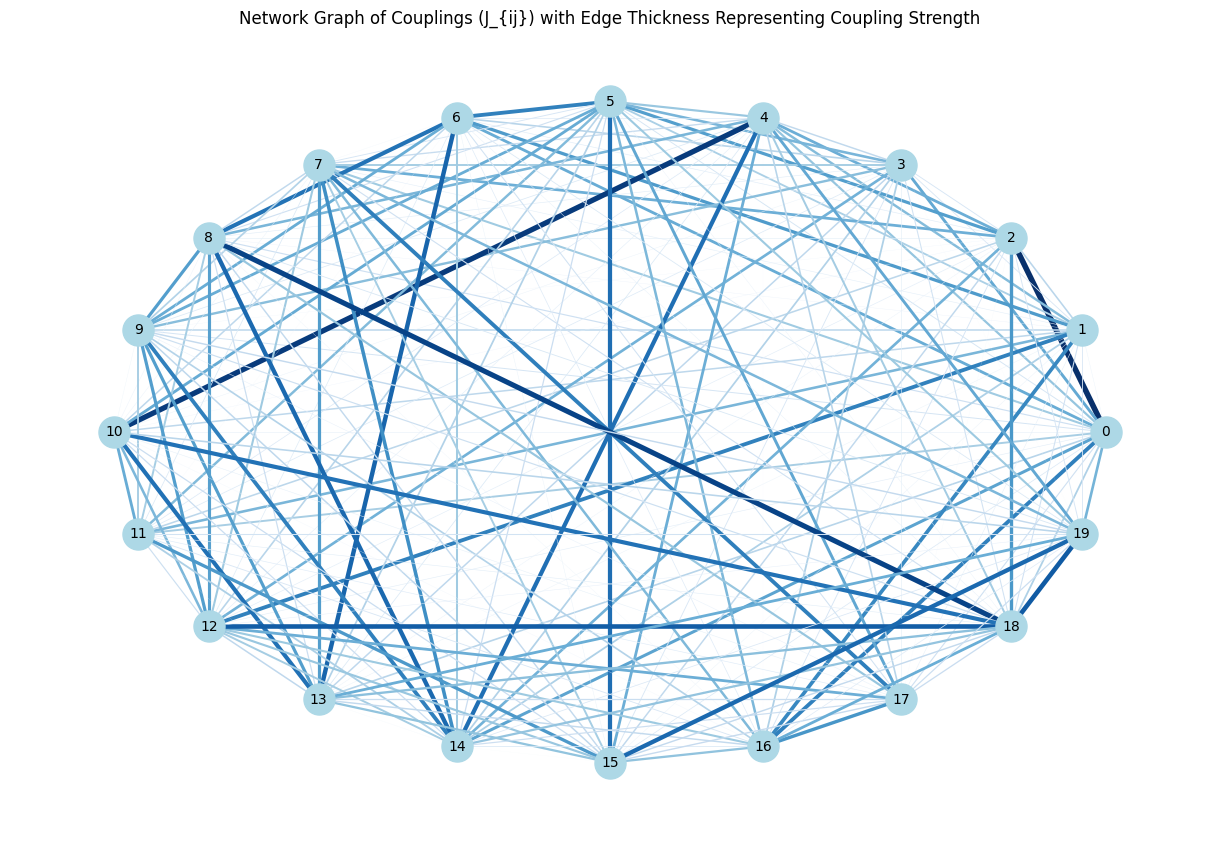

In [91]:
plot_graph(J, threshold=0.0, num_units=20)

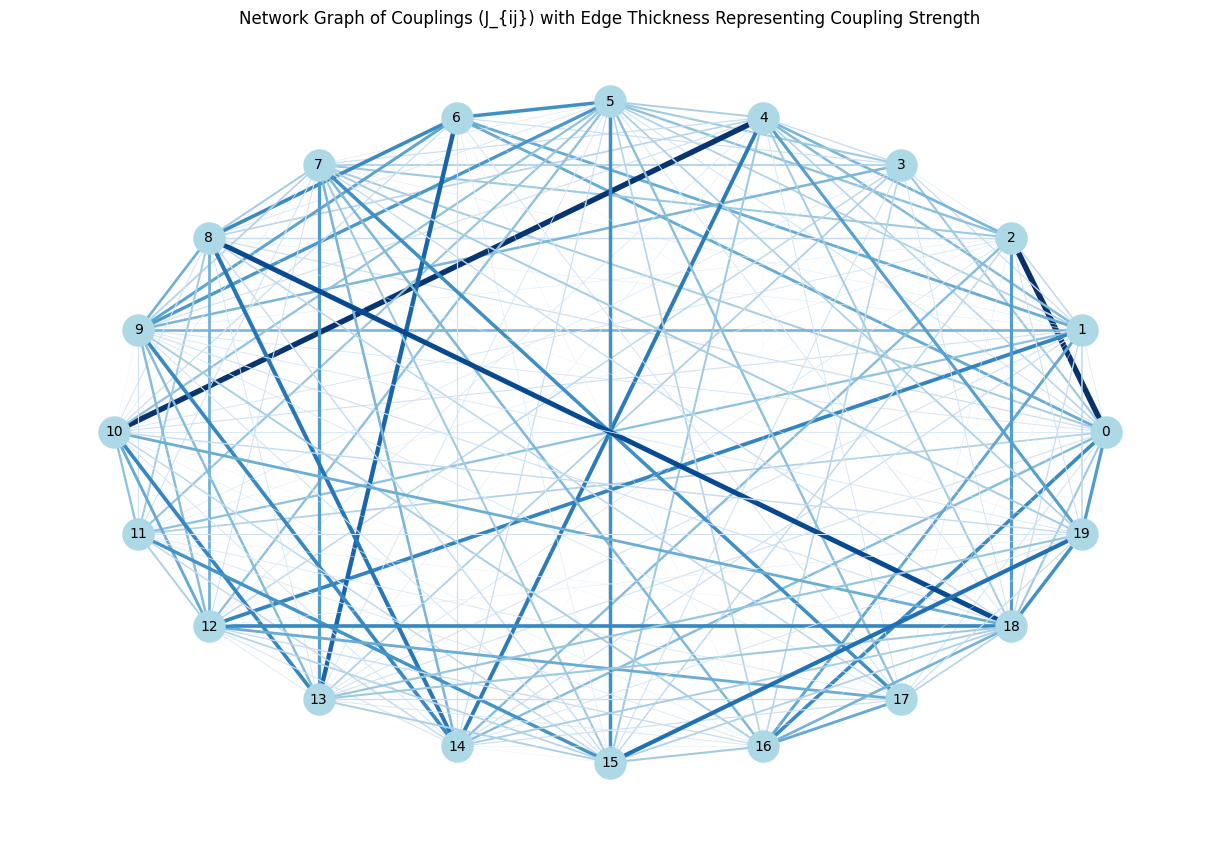

In [92]:
plot_graph(ml_model.getCouplings(), threshold=0.0, num_units=20)